# Lab 03: Pitch Classification

---
author: Qiran Hu
date: September 20, 2024
embed-resources: true
---

## Introduction

In this report, we develop a classification model to predict the type of pitch thrown by Shohei Ohtani. The differences between pitches like fastballs, sliders, curveballs, and splitters can be challenging to discern. For example, a slider and a cutter might appear similar on television but have distinct spin rates and movement patterns that set them apart. However, television broadcasts and in stadium displays overcome this challenge by utilizing advanced machine learning models that analyze real time data captured by sophisticated tracking technology. These systems measure various physical attributes of each feature variables such as "release_speed", "spin_rate", "pfx_x", "pfx_z", and "stand". Our goal is to create a similar classification model tailored specifically to Shohei Ohtani. By analyzing historical data from his pitches during the 2022 MLB season as the training data and the first half of the 2023 season as the test data, we aim to integrate advanced analytics into sports broadcasting to make the game more accessible and engaging for a diverse audience ranging from regular viewers to baseball enthusiasts. Although our model significantly improves pitch recognition for Ohtani's games, it is specialized and does not extend to predicting pitches from other pitchers or consider additional game context. 

## Methods

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_friedman1
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### Data

In [2]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)

In [3]:
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


To achieve this goal, we utilize historical pitching data from Shohei Ohtani's performances where pitches-train.parquet is the data from the 2022 MLB season as our training data and pitches-test.parquet is the data from the first half of the 2023 MLB season as our test data. Each observation contains information about a single pitch thrown by Shohei Ohtani, originates from MLB's sophisticated tracking system Statcast that records detailed information on every pitch and play.

Target Variable

pitch_name (object): This is the name of the pitch type thrown; it is the target variable our model aims to predict. This variable contains all the possible pitches that are thrown by Shohei Ohtani, which are"4-Seam Fastball", "Curveball", "Cutter", "Sinker", "Slider", "Split-Finger", and "Sweeper". 

Feature Variable

release_speed (float64): This is the velocity of the pitch in miles per hour, which is measured shortly after it leaves the pitcher's hand. Speed is usually different among pitch types; fastballs are generally faster than off speed pitches like sliders and curveballs.

release_spin_rate (float64): This is rate at which the ball spins shortly after release, which is measured in its revolutions per minute. Spin rate affects the movement and behavior of the pitch since different pitches have their unique spin rates.

pfx_x (float64): This is the horizontal deviation of the pitch from a straight line path, which is measured in feet from the catcher's perspective. Horizontal movement helps differentiate pitches that move side to side; it is crucial for distinguishing between sliders, cutters, and fastballs.

pfx_z (float64): This is the vertical deviation of the pitch from a straight-line path, which is measured in feet from the catcher's perspective. Vertical movement distinguishes pitches that move up or down, which is essential for identifying curveballs, splitters, and high spin fastballs.

stand (object): This is a "L/R" indicator that demonstrates whether the batter hits left handed or right handed. The batter's stance can influence the pitch selection and effectiveness since certain pitches are more effective against batters of a specific stance due to the direction of movement.

In [4]:
# summary statistics
pitches_train.shape[0]

2628

In [5]:
pitches_train.shape[1]

6

This training dataset has a sample size of 2628 instances and 5 unique feature variables.

In [6]:
len(pitches_train[pitches_train["pitch_name"] == "4-Seam Fastball"])

718

In [7]:
len(pitches_train[pitches_train["pitch_name"] == "4-Seam Fastball"]) / len(pitches_train)

0.2732115677321157

In [8]:
len(pitches_train[pitches_train["pitch_name"] == "Curveball"])

222

In [9]:
len(pitches_train[pitches_train["pitch_name"] == "Curveball"]) / len(pitches_train)

0.08447488584474885

In [10]:
len(pitches_train[pitches_train["pitch_name"] == "Cutter"])

233

In [11]:
len(pitches_train[pitches_train["pitch_name"] == "Cutter"]) / len(pitches_train)

0.08866057838660578

In [12]:
len(pitches_train[pitches_train["pitch_name"] == "Sinker"])

97

In [13]:
len(pitches_train[pitches_train["pitch_name"] == "Sinker"]) / len(pitches_train)

0.03691019786910198

In [14]:
len(pitches_train[pitches_train["pitch_name"] == "Slider"])

63

In [15]:
len(pitches_train[pitches_train["pitch_name"] == "Slider"]) / len(pitches_train)

0.023972602739726026

In [16]:
len(pitches_train[pitches_train["pitch_name"] == "Split-Finger"])

312

In [17]:
len(pitches_train[pitches_train["pitch_name"] == "Split-Finger"]) / len(pitches_train)

0.1187214611872146

In [18]:
len(pitches_train[pitches_train["pitch_name"] == "Sweeper"])

983

In [19]:
len(pitches_train[pitches_train["pitch_name"] == "Sweeper"]) / len(pitches_train)

0.3740487062404871

After carefully observing different patches in the dataset, I noticed that sweeper occurs the most where its proportion in all the pitches is 0.3740487062404871 and curveball is the pitch that occurs the least where ist proportion in all the pitches is 0.08447488584474885.

In [20]:
(pitches_train[pitches_train["pitch_name"] == "4-Seam Fastball"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,718.000000,714.000000,718.000000,718.000000
mean,97.270613,2217.331933,-0.288760,1.204554
std,1.699270,114.754683,0.205178,0.168139
min,90.200000,1845.000000,-0.950000,0.630000
25%,96.200000,2147.000000,-0.430000,1.100000
50%,97.400000,2215.000000,-0.300000,1.210000
75%,98.500000,2297.000000,-0.160000,1.320000
max,101.400000,2744.000000,0.250000,1.660000


In [21]:
(pitches_train[pitches_train["pitch_name"] == "Curveball"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,222.000000,222.000000,222.000000,222.000000
mean,77.679730,2482.666667,0.930045,-1.121622
std,3.215206,119.854726,0.165054,0.134629
min,68.400000,2193.000000,0.500000,-1.540000
25%,75.425000,2403.250000,0.810000,-1.210000
50%,77.700000,2492.500000,0.930000,-1.120000
75%,80.000000,2567.750000,1.030000,-1.050000
max,85.200000,2767.000000,1.370000,-0.640000


In [22]:
(pitches_train[pitches_train["pitch_name"] == "Cutter"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,233.000000,233.000000,233.000000,233.000000
mean,90.742060,2378.424893,0.296738,0.477468
std,2.364489,206.685887,0.189365,0.261247
min,82.000000,842.000000,-1.240000,-0.160000
25%,89.500000,2350.000000,0.200000,0.310000
50%,90.800000,2407.000000,0.300000,0.480000
75%,92.300000,2467.000000,0.410000,0.630000
max,97.100000,2667.000000,0.800000,1.470000


In [23]:
(pitches_train[pitches_train["pitch_name"] == "Sinker"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,97.000000,95.000000,97.000000,97.000000
mean,97.160825,1972.747368,-1.347732,0.557216
std,1.829592,143.920632,0.155781,0.205526
min,92.300000,1701.000000,-1.760000,-0.040000
25%,95.900000,1900.500000,-1.470000,0.410000
50%,97.100000,1962.000000,-1.350000,0.570000
75%,98.400000,2032.000000,-1.240000,0.710000
max,101.100000,2979.000000,-1.010000,1.020000


In [24]:
(pitches_train[pitches_train["pitch_name"] == "Slider"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,63.000000,63.000000,63.000000,63.000000
mean,85.203175,2497.619048,0.585873,-0.477619
std,2.401543,78.679306,0.208006,0.297466
min,80.500000,2341.000000,0.190000,-1.170000
25%,83.250000,2451.000000,0.440000,-0.655000
50%,85.600000,2500.000000,0.520000,-0.410000
75%,87.100000,2550.500000,0.740000,-0.265000
max,90.500000,2668.000000,1.030000,0.000000


In [25]:
(pitches_train[pitches_train["pitch_name"] == "Split-Finger"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,312.000000,312.000000,312.000000,312.000000
mean,89.291346,1273.560897,-0.456538,0.210897
std,1.759299,221.291146,0.232040,0.297955
min,84.400000,881.000000,-1.400000,-0.360000
25%,88.200000,1140.500000,-0.580000,0.020000
50%,89.350000,1248.500000,-0.435000,0.130000
75%,90.325000,1368.000000,-0.300000,0.312500
max,96.700000,2617.000000,0.270000,1.500000


In [26]:
(pitches_train[pitches_train["pitch_name"] == "Sweeper"]).describe()

,release_speed,release_spin_rate,pfx_x,pfx_z
count,983.000000,983.000000,983.000000,983.000000
mean,85.336419,2492.172940,1.170509,0.415483
std,1.862552,103.176892,0.271277,0.226349
min,79.400000,2126.000000,0.290000,-0.280000
25%,84.100000,2430.500000,0.980000,0.260000
50%,85.400000,2498.000000,1.170000,0.410000
75%,86.550000,2564.500000,1.360000,0.570000
max,90.400000,2782.000000,1.860000,1.130000


After carefully observing different patches in the dataset, I noticed that 4-Seam Fastball has the highest mean of 97.270613 and lowest standard deviation of 1.699270 in terms of its velocity while curve ball has the lowest mean of 77.679730 and highest standard deviation of 3.215206 in terms of its velocity. I also learned that slider has the highest mean of 2497.619048 and lowest standard deviation of 78.679306 in terms of its spin while split finger has the lowest mean of 1273.560897 and highest standard deviation of 221.291146 in terms of its spin.

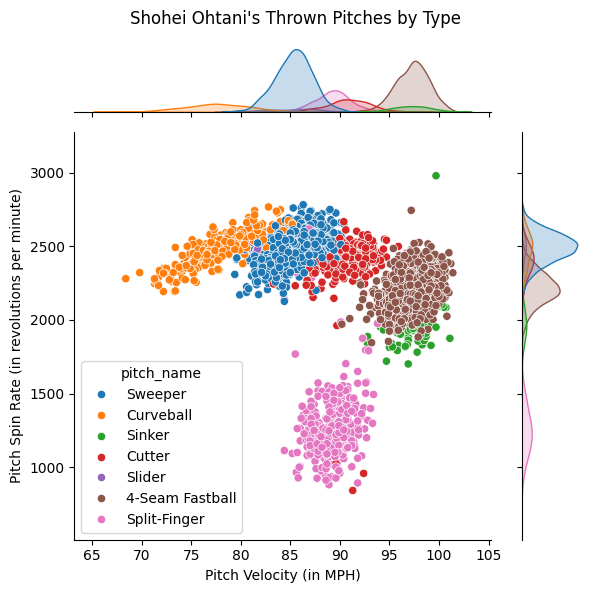

In [27]:
g = sns.jointplot(data = pitches_train, x = "release_speed", y = "release_spin_rate", hue = "pitch_name") 
g.ax_joint.set_xlabel("Pitch Velocity (in MPH)") 
g.ax_joint.set_ylabel("Pitch Spin Rate (in revolutions per minute)") 
g.figure.suptitle("Shohei Ohtani's Thrown Pitches by Type")
g.figure.tight_layout() 

The joint plot visualization of Shohei Ohtani's pitch types reveals significant insights into his pitching mechanics across pitch velocity and spin rate. This joint plot focuses on the relationship between release speed and release spin rate by providing a plot of the data points with the distribution of each variable along the axes where we color code each data points to distinguish different pitch types. Those distinct clusters provide further understanding of each type of pitch. For instance, we notice that the pitches with higher velocities tend to have lower spin rates such as the 4-seam fastball. In addition, the sweeper and the curveball s are clustered at lower velocities with a wide range of spin rates, which indicates variability in how these pitches are thrown. Meanwhile, the sinker and the cutter are concentrated in the middle velocity range with moderate spin rates. However, The split-finger  appears at lower velocities and spin rates which is different from other pitch types. As one can see, this joint plot provides a comprehensive visualization of Shohei Ohtani's diverse pitches with clear variations in pitch velocity and spin rate across different pitch types; those information are essential for enhancing automatic pitch type displaying in real-time for both the stadium and the television broadcast.

### Models

In [28]:
# process data for ML
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [29]:
# train models
categorical_features = ["stand"]
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
numeric_transformer = Pipeline([
    ("median imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("model imputer", SimpleImputer(strategy="most_frequent")),
    ("one hot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])
preprocessor = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier())
])
param_grid = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": list(range(1, 100))
}
grid_search_tree1 = GridSearchCV(pipeline, param_grid, cv = 5, scoring="accuracy")
grid_search_tree1.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('median '
                                                                                          'imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_spin_rate',
                                                                          'pfx_x',
                                                                          'pfx_z']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('model '
                                                                                          'imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one '
                                                                                          'hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['stand'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [30]:
# train models
categorical_features = ["stand"]
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
numeric_transformer = Pipeline([
    ("median imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("model imputer", SimpleImputer(strategy="most_frequent")),
    ("one hot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])
preprocessor = ColumnTransformer([
    ("numeric", numeric_transformer, numeric_features),
    ("categorical", categorical_transformer, categorical_features)
])
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier())
])
param_grid = {
    "classifier__criterion": ["gini", "entropy"],
    
    "classifier__min_samples_split": list(range(2, 100))
}
grid_search_tree2 = GridSearchCV(pipeline, param_grid, cv = 5, scoring="accuracy")
grid_search_tree2.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('median '
                                                                                          'imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_spin_rate',
                                                                          'pfx_x',
                                                                          'pfx_z']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('model '
                                                                                          'imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one '
                                                                                          'hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['stand'])])),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__min_samples_split': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, 31, ...]},
             scoring='accuracy')

In [31]:
categorical_features = ["stand"]
numeric_features = ["release_speed", "release_spin_rate", "pfx_x", "pfx_z"]
numeric_transformer = Pipeline(
    steps=[
        ("median imputer", SimpleImputer(strategy = "median")),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("model imputer", SimpleImputer(strategy = "most_frequent")),
        ("one hot", OneHotEncoder(handle_unknown="ignore", drop = "first"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features),
    ]
)
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier())
    ]
)
param_grid = {
    "classifier__n_neighbors": range(1, 100),
    "classifier__metric": ["euclidean", "manhattan"],
}
grid_search_knn = GridSearchCV(pipeline, param_grid, cv = 5, scoring = "accuracy")
grid_search_knn.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('median '
                                                                                          'imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['release_speed',
                                                                          'release_spin_rate',
                                                                          'pfx_x',
                                                                          'pfx_z']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('model '
                                                                                          'imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('one '
                                                                                          'hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['stand'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': range(1, 100)},
             scoring='accuracy')

In order to develop an effective model to predict Shohei Ohtani's pitch types, we explored and compared a decision tree classifier and a 
k nearest neighbors classifier. Since our goal is to identify the model that provides the highest accuracy in classifying pitch types based on the features variables, we performed an extensive grid search over a range of hyperparameters. For decision tree classifier, we utilized both gini and entropy as the metrics to measure the splits with values from 1 to 99 for and the values from 2 to 99 the max depth of the tree decision classifier and the min sample split of the tree decision classifier. For k nearest neighbors classifier, we conducted a grid search over the number of neighbors with values from 1 to 99 to find the optimal neighborhood size and the distance metric of euclidean and manhattan to measure measure similarity between data points. 

## Results

In [32]:
print("Best parameters:", grid_search_tree1.best_params_)
print("Test set score:", grid_search_tree1.score(X_test, y_test))

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 6}
Test set score: 0.8944444444444445


In [33]:
print("Best parameters:", grid_search_tree2.best_params_)
print("Test set score:", grid_search_tree2.score(X_test, y_test))

Best parameters: {'classifier__criterion': 'entropy', 'classifier__min_samples_split': 18}
Test set score: 0.904320987654321


In [34]:
print("Best parameters:", grid_search_knn.best_params_)
print("Test set score:", grid_search_knn.score(X_test, y_test))

Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 29}
Test set score: 0.9388888888888889


In [35]:
# report model metrics
from joblib import dump
mod = grid_search_knn.fit(X_train, y_train)
dump(mod, "pitch-classifier.joblib")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


['pitch-classifier.joblib']

After training and evaluating all the models, we compared their performance on the test dataset derived from the first half of the 2023 MLB season and obtained the following results. For decision tree classifiers, entropy with a maximum depth of 6 achieves a test accuracy of 0.8944444444444445 and entropy with a minimal samples split of 16 achieves a test accuracy of 0.904320987654321. For k nearest neighbor classifier, manhattan with a k neighbors of 29 achieves a test accuracy of 0.9388888888888889. Since the high test set score indicates better performance at capturing the complex relationships between the features and the pitch types, the k nearest neighbor classifier outperformed the decision tree classifier by around 0.03 in test accuracy which also exceed the test accuracy and the production accuracy.

## Discussion

After extensive hyperparameter tuning and evaluation, we selected the k nearest neighbor classifier over decision tree classifier as our final model.The k nearest neighbor classifier with the manhattan distance metric and k neighbor of 29 obtains an outstanding performance of 0.9388888888888889 on the test dataset, which effectively increases the predictive power of our model to accurately classify pitches in real time with feature variables of release speed, spin rate, horizontal movement, vertical movement and batter's stance.

Although our predictive model is based on a single pitcher, it is still possible to apply it all pitchers in Major League Baseball through some changes. One approach to improve the current model is to develop a generalized pitch classification model that trained on data from all available pitchers. This generalized model would be able to learn the common characteristics of each pitch type across different pitchers by capturing the fundamental relationships between pitch features and pitch type. By training on a diverse dataset that includes various pitching styles, the model will be able to make predictions to pitchers it has not seen before. Despite the fact that there is no historical data for pitcher who just started their Major League Baseball career, our model could use these some attributes to make initial predictions for new pitchers, such as fastballs are typically faster with less movements while curveballs are slower with more movements. By creating a new generalized pitch classification model that incorporates pitcher identity as a feature variable and other attributes, we can make our new model to accurately classify pitches from any pitcher. With regular updates and identity variable, we can successfully maintain the model's accuracy over time. This improvement would significantly enhance the viewing experience by providing real time pitch classification across all games, which also offers valuable insights for analysts and fans to understand the game's strategic elements. Hence, we can create a comprehensive and adaptable pitch classification system for the entire Major League Baseball.


It is appropriate to use data from the 2022 season for training and part of the 2023 season for testing because we can use the data from 2023 season as unseen dataset to test our model's predictive power. However, this approach can create potential issues on account of  changes in pitching styles over time. Pitchers often learn new pitches during the off season break time or even mid season break time. For example, a pitcher might develop a new slider or change the grip on a curveball, which means that the model that was trained on past data would not have seen this new pitch type and subsequently lead to misclassifications. Moreover, pitchers may adjust their existing pitches by changing how they throw a specific pitch, which can alter the speed, spin rate, or movement. Furthermore, injuries or changes in physical conditioning can also affect a pitcher's performance in throwing their pitches. These changes can impact model performance on account of the fact that the target variable can change over time, which results a decrease in model accuracy when predicting on future data that has shifted from the training data set. The model may have a promising cross validated accuracy in the training data. But it will indicate a lower accuracy on the test data due to these shifts in pitching styles. To address these issues, regular model updates and training the model periodically with the most recent data are crucial in helping the model to adapt to changes in pitchers' behaviors. Through the use of specific features that are less susceptible to change or the most stable and predictive features, we can the model every few weeks or months to incorporate new trends and adjustments that are made by pitcher so that our model remains a high accuracy in predicting pitch type that was thrown by different pitchers over time. 

Our predictive classifier model will not be able to predict fast enough to work in real time because the k nearest neighbors classifier model can be take a lot of computational power since the k nearest neighbor classifier makes a prediction for a new data point involves calculating the distance between that point and every point in the training dataset in order to find the k nearest neighbors, which means that the prediction time increases linearly with the size of the training data. Due to the fact that fitting the model takes around 30 seconds, it suggests that the dataset is substantial large and the preprocessing with hyperparameter tuning are also taking a lot of time. If training takes this long, the prediction phase that requires more computations against the entire training set for each new input will be even more time consuming. In a live baseball broadcast, the system needs to display the pitch type almost instantaneously after the pitch is thrown which is ideally within milliseconds. Our k nearest neighbor classifier model needs to compute distances to all training samples makes it unsuitable for such fast requirements. As more pitch data is collected throughout the season, the training dataset will grow and lead to even longer prediction times which demonstrates that our model does not scale well with increasing data points unless it is optimized. In addition, our model uses multiple features variables such as pitch speed, spin rate, horizontal and vertical movement, and batter's stance to predict the pitch type which also exacerbates the computational burden during prediction and further slowing down the response time of our predictive model. Moreover, in live broadcasts, the predictive model must operate within strict time constraints to be effective because delays in displaying information can detract from the viewer's experience. Furthermore, real time model often operate under resource limitations; allocating significant computational power to execute our k nearest neighbor classifier model may not be feasible, especially when multiple processes need to run simultaneously.

### Conclusion

As one can see, based on the concerns and issues that are discussed earlier, using the model we trained and selected for real world scenario presents several significant drawbacks that make it unsuitable for practical application. The primary issue is that the model was trained exclusively on data from Shohei Ohtani. While this allows the model to capture Shohei Ohtani's unique pitching patterns accurately, it severely limits its applicability to other pitchers in Major League Baseball because each pitcher has distinct styles and attributes that influence their pitch characteristics. Applying a model trained on one pitcher to others would likely result in inaccurate predictions. In addition to its limitations to apply to another pitch, when considering new pitchers who have yet to throw their first Major League Baseball pitch or predicting the pitchers' first throws on Major League Baseball games, this new model could face some challenges since it is making predictions without prior data on these individuals. Hence, without the training data from many pitchers, this model may not be able to make reasonable predictions for new pitchers based on the general relationships between feature variables and target variable. In order to  function effectively in a real world scenario, the model must provide predictions almost instantaneously. However, given that fitting the model takes around 30 seconds, the current model's prediction time is directly tied to the size of the training dataset and involves complex distance computations, which is  unlikely to meet the real time demands of live baseball broadcasts. Thus, we would not recommend using current model in automatically displaying the pitch type for each pitch in real-time for both the stadium and on the television broadcast.